# Plot longitude-averaged T, S,ocean trends by depth/lat 


In [1]:
#set up: import packages 
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cf_xarray as cf
import pandas as pd
import gc #garbage collector


from dask.distributed import Client
Client=Client()

## Inputs

In [16]:
#spatial domain
latmax = -50. ; latmin = -75. ; zmax = 2000.
sectorNam = 'Weddell' ;lonmin = 310. ; lonmax = 15.

#time domain 
yrst = 2006 ; yren   = 2024 



# ocean data
diri = '/g/data/jk72/wrh581/'
src  = 'EN4'
prefix = src+'/EN.4.2.2.?.analysis.l09.'
sNam = 'salinity' ; tNam = 'temperature'   #variable names


#output filepath
dirp = '/g/data/jk72/wrh581/Obs-seaice_analysis/plots/'
filp = src+'_'+sectorNam+'_trend_lat-depth.png'

Read data

In [17]:


#get file list for all years and months in range
yrstring = [str(yr) for yr in  np.arange(yrst,yren+1) ]        #string list of years
cmd = 'ls '+diri+prefix+'{'+','.join(yrstring)+'}??.nc 2>/dev/null'  #unix command
fpath = !$cmd

data = xr.open_mfdataset(fpath, parallel=True).cf.sel(latitude = slice(latmin, latmax), vertical=slice(0,zmax))

#longitude selection
if lonmax > lonmin:
    data = data.cf.sel(longitude = slice(lonmin, lonmax)).cf.mean('longitude')
else:
    data = data.cf.sel(longitude = (data.lon <= lonmax) | (data.lon > lonmin)).cf.mean('longitude')


### calculate trend

In [18]:

trend = []

for var in [tNam,sNam]:
    anom = data[var].groupby('time.month')  - data[var].groupby('time.month').mean('time')
    anom['time'] = anom.time.dt.year + anom.time.dt.month / 12.0 + anom.time.dt.day / 365.25
    tmp  = anom.polyfit('time',deg=1, skipna=True)
    tmp  = tmp['polyfit_coefficients'].sel(degree=1)
    tmp = tmp * 10
    trend.append(tmp.compute())





/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/indexing.py:1593: PerformanceWarning: Slicing with an out-of-order index is generating 19 times more chunks
  return self.array[key]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/indexing.py:1593: PerformanceWarning: Slicing with an out-of-order index is generating 19 times more chunks
  return self.array[key]


Text(0.5, 1.0, 'salinity')

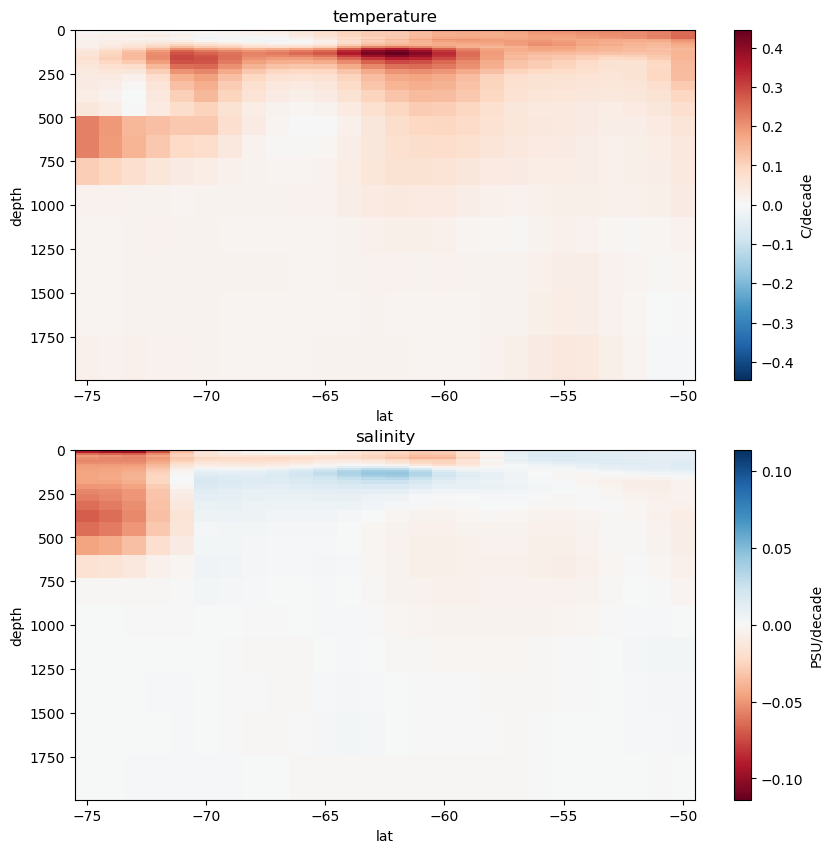

In [20]:
plt.figure(figsize = (10,10))

plt.subplot(2,1,1)
trend[0].plot(yincrease=False, cbar_kwargs={'label' : 'C/decade'})
plt.title(tNam)


plt.subplot(2,1,2)
trend[1].plot(yincrease=False, cmap = 'RdBu', cbar_kwargs={'label' : 'PSU/decade'})
plt.title(sNam)